In [149]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import innvestigate
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform,data,color
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

In [3]:
#prepare dataset
def load_data(s):
    data = []
    n = glob.glob(s+"/NORMAL/*jpeg")
    p = glob.glob(s+"/PNEUMONIA/*jpeg")
    
    for f in n:
        tmp = [f,0]
        data.append(tmp)
        
    for f in p:
        tmp = [f,1]
        data.append(tmp)
    
    shuffle(data)
    
    return data

In [4]:
#loading training data
train = load_data("train")
test = load_data("test")
validation = load_data("val")

In [5]:
len(train)

5216

In [6]:
train[:5]

[['train/NORMAL/NORMAL2-IM-1329-0001.jpeg', 0],
 ['train/NORMAL/IM-0207-0001.jpeg', 0],
 ['train/PNEUMONIA/person1702_bacteria_4508.jpeg', 1],
 ['train/PNEUMONIA/person1609_virus_2790.jpeg', 1],
 ['train/PNEUMONIA/person382_bacteria_1738.jpeg', 1]]

In [7]:
len(test)

624

In [8]:
test[:5]

[['test/PNEUMONIA/person134_bacteria_641.jpeg', 1],
 ['test/PNEUMONIA/person120_bacteria_572.jpeg', 1],
 ['test/PNEUMONIA/person83_bacteria_411.jpeg', 1],
 ['test/PNEUMONIA/person147_bacteria_711.jpeg', 1],
 ['test/NORMAL/IM-0059-0001.jpeg', 0]]

In [9]:
len(validation)

16

In [10]:
#checking a random sample image
train[0][0]

'train/NORMAL/NORMAL2-IM-1329-0001.jpeg'

(-0.5, 1437.5, 1174.5, -0.5)

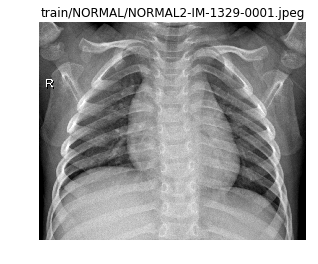

In [30]:
im = io.imread(train[0][0],as_gray=True)
#im = color.rgb2gray(im)
plt.title(train[0][0])
plt.imshow(im,cmap='gray')
plt.axis('off')

In [12]:
im

array([[115, 111, 106, ..., 104, 104, 108],
       [102, 112, 108, ..., 106, 108, 108],
       [ 96, 107, 115, ..., 107, 109, 106],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [13]:
im.shape

(1175, 1438)

In [45]:
def generator(name):
    datagen = ImageDataGenerator(rescale = 1./255)
    dataset = datagen.flow_from_directory(name,
                                          target_size = (64, 64),
                                          batch_size = 32,
                                          class_mode = 'binary')
    return dataset

In [171]:
#Build model

model_1 = Sequential()

model_1.add(Convolution2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Convolution2D(32, (3, 3), activation="relu"))

model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Flatten())

model_1.add(Dense(units = 128, activation = 'relu'))
model_1.add(Dense( units = 1, activation = 'sigmoid'))

In [172]:
model_1.compile( loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [173]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total para

In [174]:
model_1.fit_generator(generator('train'),
                      steps_per_epoch = 163,
                      epochs = 10)

Found 5216 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 176s 1s/step - loss: 0.2348 - acc: 0.9059
Epoch 2/10
163/163 [==============================] - 183s 1s/step - loss: 0.1095 - acc: 0.9574
Epoch 3/10
163/163 [==============================] - 175s 1s/step - loss: 0.0817 - acc: 0.9689
Epoch 4/10
163/163 [==============================] - 175s 1s/step - loss: 0.0826 - acc: 0.9693
Epoch 5/10
163/163 [==============================] - 174s 1s/step - loss: 0.0616 - acc: 0.9768
Epoch 6/10
163/163 [==============================] - 213s 1s/step - loss: 0.0569 - acc: 0.9783
Epoch 7/10
163/163 [==============================] - 174s 1s/step - loss: 0.0497 - acc: 0.9824
Epoch 8/10
163/163 [==============================] - 173s 1s/step - loss: 0.0529 - acc: 0.9804
Epoch 9/10
163/163 [==============================] - 174s 1s/step - loss: 0.0374 - acc: 0.9849
Epoch 10/10
163/163 [==============================] - 174s 1s/step - loss: 0.0368 - acc: 0.98

In [175]:
test_acc = model_1.evaluate_generator(generator('test'),steps=624)

Found 624 images belonging to 2 classes.


In [178]:
test_acc[1] * 100

79.83258011503698

In [19]:
model_1.save_weights("chestxraymodel.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
model_json = model_1.to_json()
with open("chestxraymodel.json", "w") as json_file:
    json_file.write(model_json)

## Can we explain what happens

In [60]:
def process_img(name):
    datagen = ImageDataGenerator(rescale = 1./255)
    dataset = datagen.flow_from_directory(name,
                                          target_size = (64, 64),
                                          batch_size = 1,
                                          class_mode = 'binary')
    return dataset

## Loading saved model

In [152]:
json_file = open('chestxraymodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("chestxraymodel.h5")

In [74]:
weights = loaded_model.weights
weights

[<tf.Variable 'conv2d_1_1/kernel:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_2_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'dense_1_1/kernel:0' shape=(6272, 128) dtype=float32_ref>,
 <tf.Variable 'dense_1_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dense_2_1/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dense_2_1/bias:0' shape=(1,) dtype=float32_ref>]

In [72]:
layer_outputs = [layer.output for layer in loaded_model.layers] 
layer_outputs

[<tf.Tensor 'conv2d_1_1/Relu:0' shape=(?, 62, 62, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1_1/MaxPool:0' shape=(?, 31, 31, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2_1/Relu:0' shape=(?, 29, 29, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2_1/MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>,
 <tf.Tensor 'flatten_1_1/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_1_1/Relu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'dense_2_1/Sigmoid:0' shape=(?, 1) dtype=float32>]

In [28]:
from keras import models
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)

In [61]:
x,y = next(process_img('train'))
x.shape

Found 5216 images belonging to 2 classes.


(1, 64, 64, 3)

In [108]:
activations = activation_model.predict(x) 

In [97]:
len(activations)

7

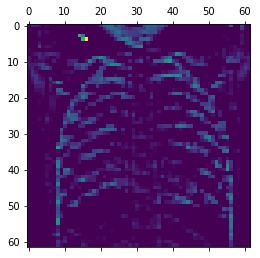

In [67]:
first_layer = activations[0]
plt.matshow(first_layer[0, :, :, 4], cmap='viridis')

In [79]:
act_weights = {}
for layer in layer_outputs:
    name = layer.name.split("/")[0]
    
    for w in weights:
        if name == w.name.split("/")[0] and 'kernel' in w.name.split("/")[1]:
            act_weights[name] = w

In [128]:
import tensorflow as tf
from tensorflow.python.ops import gen_nn_ops

epsilon = 1e-10

def backprop_fc(name, activation, relevance):
    print(activation.shape)
    w = act_weights[name]
    w_pos = tf.maximum(0.0, w)
    z = tf.matmul(activation, w_pos) + epsilon
    s = relevance / z
    c = tf.matmul(s, tf.transpose(w_pos))
    return c * activation

def backprop_flatten(activation, relevance):
    print(activation.shape)
    shape = [dim for dim in activation.shape]
    shape[0] = -1
    return tf.reshape(relevance, shape)

def backprop_max_pool2d(activation, relevance, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1]):
    print(activation.shape)
    z = tf.nn.max_pool(activation, ksize, strides, padding='SAME') + epsilon
    s = relevance / z
    c = gen_nn_ops.max_pool_grad_v2(activation, z, s, ksize, strides, padding='SAME')
    return c * activation

def backprop_conv2d(name, activation, relevance, strides=[1, 1, 1, 1]):
    w = act_weights[name]
    w_pos = tf.maximum(0.0, w)
    z = tf.nn.conv2d(activation, w_pos, strides, padding='SAME') + epsilon
    s = relevance / z
    c = tf.nn.conv2d_backprop_input(tf.shape(activation), w_pos, s, strides, padding='SAME')
    return c * activation

In [114]:
act = activations[:0:-1]
layers_rev = layer_outputs[:0:-1]

In [150]:
relevances = [act[0]]

for i in range(1,len(activations)-3):
    name = layers_rev[i-1].name.split('/')[0]
    if 'dense' in name or 'fc' in name:
        print(name)
        relevances.append(backprop_fc(name, act[i], relevances[-1]))
    elif 'flatten' in name:
        print(name)
        relevances.append(backprop_flatten(act[i], relevances[-1]))
    elif 'max_pool' in name:
        print(name)
        relevances.append(backprop_max_pool2d(act[i], relevances[-1]))
    elif 'conv' in name:
        print(name)
        relevances.append(backprop_conv2d(name,act[i], relevances[-1]))
    else:
        print('Error parsing layer!')

dense_2_1
(1, 128)
dense_1_1
(1, 6272)
flatten_1_1
(1, 14, 14, 32)


In [122]:
for activation in activations:
    print(activation.shape)

(1, 62, 62, 32)
(1, 31, 31, 32)
(1, 29, 29, 32)
(1, 14, 14, 32)
(1, 6272)
(1, 128)
(1, 1)


In [123]:
for w in weights:
    print(w.shape)

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(6272, 128)
(128,)
(128, 1)
(1,)


In [132]:
relevances

[array([[0.00155133]], dtype=float32),
 <tf.Tensor 'mul_14:0' shape=(1, 128) dtype=float32>,
 <tf.Tensor 'mul_15:0' shape=(1, 6272) dtype=float32>,
 <tf.Tensor 'Reshape_5:0' shape=(1, 14, 14, 32) dtype=float32>]

In [134]:
analyzer = innvestigate.create_analyzer("deep_taylor", loaded_model)

In [141]:
a = analyzer.analyze(x)

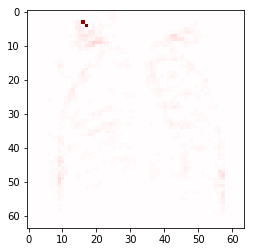

In [142]:
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

y

In [144]:
y[0]

0.0

In [146]:
itr = process_img('train')
while True:
    x,y = next(itr)
    if y[0] == 1.0:
        break
        


Found 5216 images belonging to 2 classes.


In [147]:
a = analyzer.analyze(x)

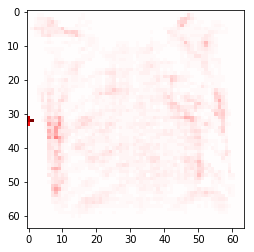

In [148]:
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))